# Tutorial 17: Self-Supervised Contrastive Learning with SimCLR

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial17/SimCLR.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial17/SimCLR.ipynb)  
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial17)     
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We will report the speed comparisons of the PyTorch and JAX implementation soon.
    
| Models                |   PyTorch   |     JAX     |
|-----------------------|:-----------:|:-----------:|
| SimCLR                |  -min  -sec |  -min  -sec |
| Logistic Regression   |  -min  -sec |  -min  -sec |
| Supervised ResNet-18  |  -min  -sec |  -min  -sec |

---

In this tutorial, we will take a closer look at self-supervised contrastive learning. Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way. However, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task. 
The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available. The subfield that we will focus on in this tutorial is contrastive learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="../../tutorial17/simclr_contrastive_learning.png" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way. Let's first start with importing our standard libraries below:

In [1]:
## Standard libraries
import os
import numpy as np
from typing import Sequence, Any
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial17_jax"

print('Device:', jax.devices()[0])

Device: gpu:0


As in many tutorials before, we provide pre-trained models. Note that those models are slightly larger as normal (~100MB overall) since we use the default ResNet-18 architecture. If you are running this notebook locally, make sure to have sufficient disk space available.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such, specialized for JAX. Next, we implement SimCLR with Flax, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [3]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="../../tutorial17/simclr_data_augmentations.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="../../tutorial17/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features. If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur. In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). In our experiments, this setting obtained better performance and was faster and more stable to train. If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial since the model can't rely on this information anymore to distinguish between images.

### Image Augmentations with JAX

In the [PyTorch version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html) of this tutorial, we implement all these augmentations with transformation from the [torchvision](https://pytorch.org/vision/stable/index.html) library. This requires a considerable amount of compute from the CPU to prepare the data in time for using it on the GPU. As alternative, we show here an implementation with JAX-native transformations in [Pix](https://dm-pix.readthedocs.io/en/latest/) that are executed on GPU on batch-level, using `jax.vmap` and `jax.jit`. Still, one transformation that can be difficult in JAX is resize-and-crop, since the resize creates arrays of dynamic shapes. Hence, we use the `RandomResizedCrop` transformation from torchvision:

In [4]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255.
    return img
    

contrast_transforms = transforms.Compose([transforms.RandomResizedCrop(size=96),
                                          image_to_numpy])

[Pix](https://dm-pix.readthedocs.io/en/latest/) is an image-processing library in JAX, developed by Deep mind, that implements most common data augmentations. Let's first import it below:

In [5]:
try:
    import dm_pix
except ModuleNotFoundError: # Install pix if missing
    !pip install --quiet dm_pix
    import dm_pix

As a first step, we implement a function that augments a single image and applies a random horizontal flip, color jitter (brightness, contrast, saturation, and hue), random grayscaling, and gaussian blur. Since these are operations with stochaticity/randomness, we also pass a random seed with it that we can split for each operation.

In [6]:
def augment_image(rng, img):
    rngs = random.split(rng, 8)
    # Random left-right flip
    img = dm_pix.random_flip_left_right(rngs[0], img)
    # Color jitter
    img_jt = img
    img_jt = img_jt * random.uniform(rngs[1], shape=(1,), minval=0.5, maxval=1.5)  # Brightness
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    img_jt = dm_pix.random_contrast(rngs[2], img_jt, lower=0.5, upper=1.5)
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    img_jt = dm_pix.random_saturation(rngs[3], img_jt, lower=0.5, upper=1.5)
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    img_jt = dm_pix.random_hue(rngs[4], img_jt, max_delta=0.1)
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    should_jt = random.bernoulli(rngs[5], p=0.8)
    img = jnp.where(should_jt, img_jt, img)
    # Random grayscale
    should_gs = random.bernoulli(rngs[6], p=0.2)
    img = jax.lax.cond(should_gs,  # Only apply grayscale if true
                       lambda x: dm_pix.rgb_to_grayscale(x, keep_dims=True),
                       lambda x: x,
                       img)
    # Gaussian blur
    sigma = random.uniform(rngs[7], shape=(1,), minval=0.1, maxval=2.0)
    img = dm_pix.gaussian_blur(img, sigma=sigma[0], kernel_size=9)
    # Normalization
    img = img * 2.0 - 1.0
    return img

You might have noticed that we do not use the function `dm_pix.random_brightness` for the brightness augmentation. The reason is that the implementation follows TensorFlow's brightness augmentation by adding a constant value to each pixel, while the implementation in torchvision and [PIL](https://pillow.readthedocs.io/en/stable/) scales the pixel values by the factor. To stay closer to the PyTorch implementation, we implement it ourselves by scaling the pixel values.

Now that we have a function to augment a single image, let's transform this function to allow for a batch of images. This can be done using `jax.vmap`, with which we can vectorize the function both over images and seeds, such that each image is differently augmented. To not have to pass $N$ seeds for a batch of $N$ images, we can simply split one seed $N$ times before calling the augmentation function. Finally, let's optimize the whole augmentation pipeline by just-in-time compilation:

In [7]:
parallel_augment = jax.jit(lambda rng, imgs: jax.vmap(augment_image)(random.split(rng, imgs.shape[0]), imgs))

In contrast to the PyTorch implementation, this augmentation will be performed on GPU, integrated in the training step for contrastive learning. The benefit of this is that we require much less CPU compute power and don't have to worry much about having enough workers etc. in the data loader. However, the apparent disadvantage is that we strictly block the GPU for the augmentations. But will this even be noticable in practice? We can easily check that by timing the execution for our augmentations on an arbitrary batch of images:

In [8]:
img_rng, augm_rng = random.split(random.PRNGKey(42))
rand_imgs = random.uniform(img_rng, (512, 96, 96, 3))
_ = parallel_augment(augm_rng, rand_imgs)

In [9]:
%%timeit
_ = parallel_augment(augm_rng, rand_imgs)

8.29 ms ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Even for this very large batch of images, the augmentation takes only a few milliseconds on a common GPU, while a training step of a ResNet-18, as we will see later, takes several magnitudes more (e.g. about 200ms on an NVIDIA GTX1080Ti). Hence, we will not really notice this extra computation during training, while being much more efficient in CPU usage.

### STL10 dataset

After discussing the data augmentation techniques, we can now focus on the dataset. In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

Luckily, the STL10 dataset is provided through torchvision. Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download. For our initial discussion of self-supervised learning and SimCLR, we will create two data loaders with our contrastive transformations above: the `unlabeled_data` will be used to train our model via contrastive learning, and `train_data_contrast` will be used as a validation set in contrastive learning.

In [10]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, 
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

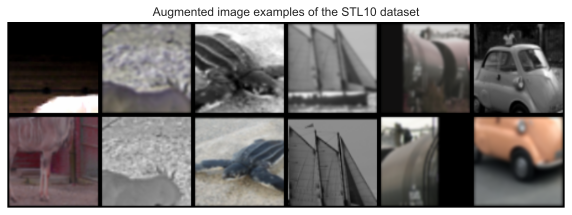

In [11]:
# Visualize some examples
NUM_IMAGES = 6
imgs = np.stack([parallel_augment(random.PRNGKey(idx), np.stack(unlabeled_data[idx][0], axis=0)) for idx in range(NUM_IMAGES)], axis=2)
imgs = (imgs + 1.0) / 2.0
img_grid = np.pad(imgs, ((0,0), (2,2), (0,0), (2,2), (0,0)))
img_grid = img_grid.reshape(img_grid.shape[0]*img_grid.shape[1],-1,img_grid.shape[-1])

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="../../tutorial17/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a Flax module. To not implement ResNet-18 ourselves, we use [flaxmodels](https://github.com/matthias-wright/flaxmodels) as we have already done in [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html).

In [12]:
# Import and install flaxmodels if needed
try:
    import flaxmodels
except ModuleNotFoundError:
    !pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
    import flaxmodels

In [13]:
class SimCLR(nn.Module):
    hidden_dim : int
    temperature : float
    
    def setup(self):
        # Base model f(.) - ResNet 18 with last layer being size of 4*hidden_dim
        self.convnet = flaxmodels.ResNet18(output='activations', 
                                           pretrained=False, 
                                           normalize=False,
                                           num_classes=4*self.hidden_dim)
        # Network g(.) as MLP with last fc layer of convnet
        self.head = nn.Sequential([
            nn.relu,
            nn.Dense(self.hidden_dim)
        ])
        
    def __call__(self, imgs, train=True):
        # Encode all images
        model_feats = self.convnet(imgs, train=train)
        feats = self.head(model_feats['fc'])
        
        # Calculate cosine similarity between all images
        cos_sim = optax.cosine_similarity(feats[:,None,:], feats[None,:,:])
        cos_sim /= self.temperature
        # Masking cosine similarities to itself
        diag_range = jnp.arange(feats.shape[0], dtype=jnp.int32)
        cos_sim = cos_sim.at[diag_range, diag_range].set(-9e15)
        # Find positive example -> batch_size//2 away from the original example
        shifted_diag = jnp.roll(diag_range, imgs.shape[0]//2)
        pos_logits = cos_sim[diag_range, shifted_diag]
        # InfoNCE loss
        nll = - pos_logits + nn.logsumexp(cos_sim, axis=-1)
        nll = nll.mean()
        
        # Logging
        metrics = {'loss': nll}
        # Determine ranking position of positive example
        comb_sim = jnp.concatenate([pos_logits[:,None],
                                    cos_sim.at[shifted_diag, diag_range].set(-9e15)],
                                   axis=-1)
        sim_argsort = (-comb_sim).argsort(axis=-1).argmin(axis=-1)
        # Logging of ranking position
        metrics['acc_top1'] = (sim_argsort == 0).mean()
        metrics['acc_top5'] = (sim_argsort < 5).mean()
        metrics['acc_mean_pos'] = (sim_argsort + 1).mean()
        
        return nll, metrics
    
    def encode(self, imgs, train=False):
        # Return features before g(.)
        model_feats = self.convnet(imgs, train=train)
        return model_feats['block4_1'].mean(axis=(1,2))

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that. However, in this tutorial, we will restrict ourselves to the STL10 dataset where we use the task of image classification on STL10 as our test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. We extend the TrainState with a `batch_stats` attribute for the batch statistics, and an PRNG key `rng` for the augmentations during training.

In [14]:
class TrainState(train_state.TrainState):
    # Batch statistics from BatchNorm
    batch_stats : Any
    # PRNGKey for augmentations
    rng : Any

The class `TrainerModule` will build the foundation for our training code and will be specialized for the different parts/models in this tutorial.

In [15]:
class TrainerModule:

    def __init__(self, 
                 model_name : str, 
                 model_class : Any, 
                 eval_key : str, 
                 exmp_imgs : Any, 
                 lr : float = 1e-3, 
                 weight_decay : float = 0.01, 
                 seed : int = 42, 
                 check_val_every_n_epoch : int = 1, 
                 **model_hparams):
        """
        Module for summarizing all common training functionalities.

        Inputs:
            model_name - Folder name in which to save the checkpoints
            model_class - Module class of the model to train
            eval_key - Name of the metric to check for saving the best model
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
            check_val_every_n_epoch - With which frequency to validate the model
        """
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.seed = seed
        self.check_val_every_n_epoch = check_val_every_n_epoch
        # Create empty model. Note: no parameters yet
        self.eval_key = eval_key
        self.model_name = model_name
        self.model = model_class(**model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'{self.model_name}/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)
        
    def create_functions(self):
        # To be implemented in sub-classes
        raise NotImplementedError

    def init_model(self, exmp_imgs):
        # Initialize model
        rng = random.PRNGKey(self.seed)
        rng, init_rng = random.split(rng)
        variables = self.model.init(init_rng, exmp_imgs)
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=variables['params'],
                                batch_stats=variables.get('batch_stats'),
                                rng=rng,
                                tx=None, opt_state=None)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # By default, we decrease the learning rate with cosine annealing
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=0.0,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=2e-2*self.lr
        )
        optimizer = optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        self.create_train_state(optimizer)
        
    def create_train_state(self, optimizer):
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       batch_stats=self.state.batch_stats,
                                       rng=self.state.rng,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval metric
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % self.check_val_every_n_epoch == 0:
                eval_metrics = self.eval_model(val_loader)
                for key in eval_metrics:
                    self.logger.add_scalar(f'val/{key}', eval_metrics[key], global_step=epoch_idx)
                if eval_metrics[self.eval_key] >= best_eval:
                    best_eval = eval_metrics[self.eval_key]
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, data_loader, epoch):
        # Train model for one epoch, and log avg metrics
        metrics = defaultdict(float)
        for batch in tqdm(data_loader, desc='Training', leave=False):
            self.state, batch_metrics = self.train_step(self.state, batch)
            for key in batch_metrics:
                metrics[key] += batch_metrics[key]
        num_train_steps = len(data_loader)
        for key in metrics:
            avg_val = metrics[key].item() / num_train_steps
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg metrics
        metrics = defaultdict(float)
        count = 0
        for batch_idx, batch in enumerate(data_loader):
            batch_metrics = self.eval_step(self.state, random.PRNGKey(batch_idx), batch)
            batch_size = (batch[0] if isinstance(batch, (tuple, list)) else batch).shape[0]
            count += batch_size
            for key in batch_metrics:
                metrics[key] += batch_metrics[key] * batch_size
        metrics = {key: metrics[key].item() / count for key in metrics}
        return metrics

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params, 
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        num_params = sum([np.prod(p.shape) for p in jax.tree_leaves(state_dict)])
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       rng=self.state.rng,
                                       tx=self.state.tx if self.state.tx else optax.sgd(self.lr)  # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

We specialize this training module for SimCLR below. For saving the best model checkpoint, we track the metric `acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [16]:
class SimCLRTrainer(TrainerModule):
    
    def __init__(self, **kwargs):
        super().__init__(model_name='SimCLR',
                         model_class=SimCLR,
                         eval_key='acc_top5',
                         **kwargs)
        
    def create_functions(self):
        # Function to calculate the InfoNCE loss for a batch of images
        def calculate_loss(params, batch_stats, rng, batch, train):
            batch = parallel_augment(rng, batch)
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    batch,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            (loss, metrics), new_model_state = outs if train else (outs, None)
            return loss, (metrics, new_model_state)
        # Training function
        def train_step(state, batch):
            rng, forward_rng = random.split(state.rng)
            loss_fn = lambda params: calculate_loss(params, 
                                                    state.batch_stats, 
                                                    forward_rng, 
                                                    batch, 
                                                    train=True)
            (_, (metrics, new_model_state)), grads = jax.value_and_grad(loss_fn, 
                                                                        has_aux=True)(state.params)
            # Update parameters, batch statistics and PRNG key
            state = state.apply_gradients(grads=grads, 
                                          batch_stats=new_model_state['batch_stats'],
                                          rng=rng)
            return state, metrics
        # Eval function
        def eval_step(state, rng, batch):
            _, (metrics, _) = calculate_loss(state.params, 
                                             state.batch_stats, 
                                             rng, 
                                             batch, 
                                             train=False)
            return metrics
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

Finally, let's prepare the data loaders and write a full training function:

In [17]:
def numpy_collate_contrastive(batch):
    imgs1, imgs2 = [[b[0][i] for b in batch] for i in range(2)]
    return np.stack(imgs1 + imgs2, axis=0)


batch_size = 256
simclr_train_loader = data.DataLoader(unlabeled_data,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True,
                                      collate_fn=numpy_collate_contrastive,
                                      num_workers=3,
                                      persistent_workers=True,
                                      generator=torch.Generator().manual_seed(42))
simclr_val_loader = data.DataLoader(train_data_contrast,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    drop_last=False,
                                    collate_fn=numpy_collate_contrastive,
                                    num_workers=3,
                                    persistent_workers=True)

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [18]:
def train_simclr(num_epochs=500, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = SimCLRTrainer(exmp_imgs=parallel_augment(random.PRNGKey(0),
                                                       next(iter(simclr_train_loader))),
                            **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(simclr_train_loader, simclr_val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    return trainer

With everything ready, let's train the model:

In [19]:
simclr_trainer = train_simclr(hidden_dim=128, 
                              lr=5e-4, 
                              temperature=0.07, 
                              weight_decay=1e-4, 
                              num_epochs=500)

To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [20]:
# %tensorboard --logdir ../../saved_models/tutorial17_jax/tensorboards/SimCLR/

<center width="100%"><img src="tensorboard_simclr.png" width="1200px"></center>

One thing to note is that contrastive learning benefits a lot from long training. The shown plot above is from a training that took approx. 16 hrs on a NVIDIA GTX 1080Ti. Training the model for even longer might reduce its loss further, but we did not experience any gains from it for the downstream task on image classification. In general, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available. 

## Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [21]:
class LogisticRegression(nn.Module):
    num_classes : int
    
    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.num_classes)(x)

In [22]:
class LGTrainer(TrainerModule):
    
    def __init__(self, model_suffix, **kwargs):
        super().__init__(model_name=f'LogisticRegression_{model_suffix}',
                         model_class=LogisticRegression,
                         eval_key='acc',
                         check_val_every_n_epoch=10,
                         **kwargs)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate with a stepwise function
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.8): 0.1}
        )
        optimizer = optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        self.create_train_state(optimizer)
        
    def create_functions(self):
        # Function to calculate the classification loss and accuracy
        def calculate_loss(params, batch):
            imgs, labels = batch
            logits = self.model.apply({'params': params}, imgs)
            labels_onehot = nn.one_hot(labels, logits.shape[-1])
            loss = optax.softmax_cross_entropy(logits, labels_onehot).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            metrics = {'loss': loss, 'acc': acc}
            return loss, metrics
        # Training function
        def train_step(state, batch):
            (_, metrics), grads = jax.value_and_grad(calculate_loss, 
                                                     has_aux=True)(state.params, batch)
            state = state.apply_gradients(grads=grads)
            return state, metrics
        # Eval function
        def eval_step(state, rng, batch):
            _, metrics = calculate_loss(state.params, batch)
            return metrics
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [23]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


img_transforms = transforms.Compose([image_to_numpy,
                                     lambda img: (img * 2.0 - 1.0)])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [24]:
class NumpyDataset(data.Dataset):
    # data.TensorDataset for numpy arrays
    
    def __init__(self, *arrays):
        self.arrays = arrays
        
    def __len__(self):
        return self.arrays[0].shape[0]
    
    def __getitem__(self, idx):
        return [arr[idx] for arr in self.arrays]

In [25]:
def prepare_data_features(encode_fn, dataset):
    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, 
                                  shuffle=False, 
                                  drop_last=False,
                                  collate_fn=numpy_collate)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_feats = encode_fn(batch_imgs)
        feats.append(jax.device_get(batch_feats))
        labels.append(batch_labels)
    
    feats = np.concatenate(feats, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Sort images by labels for easier postprocessing later
    idxs = labels.argsort()
    labels, feats = labels[idxs], feats[idxs]
    
    return NumpyDataset(feats, labels)

Let's apply the function to both training and test set below.

In [26]:
simclr_model = simclr_trainer.model.bind({'params': simclr_trainer.state.params, 
                                          'batch_stats': simclr_trainer.state.batch_stats})
encode_fn = jax.jit(lambda img: simclr_model.encode(img))
train_feats_simclr = prepare_data_features(encode_fn, train_img_data)
test_feats_simclr = prepare_data_features(encode_fn, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [27]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, num_epochs=100, **kwargs):
    # Data loaders
    train_loader = data.DataLoader(train_feats_data, 
                                   batch_size=batch_size, 
                                   shuffle=True, 
                                   drop_last=False, 
                                   generator=torch.Generator().manual_seed(42),
                                   collate_fn=numpy_collate)
    test_loader = data.DataLoader(test_feats_data, 
                                  batch_size=batch_size, 
                                  shuffle=False, 
                                  drop_last=False,
                                  collate_fn=numpy_collate)

    # Create a trainer module with specified hyperparameters
    trainer = LGTrainer(exmp_imgs=next(iter(train_loader))[0],
                        model_suffix=model_suffix,
                        **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, test_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    
    # Test best model on train and validation set
    train_result = trainer.eval_model(train_loader)
    test_result = trainer.eval_model(test_loader)
    result = {"train": train_result["acc"], "test": test_result["acc"]}
        
    return trainer, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [28]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_arrays = [t.reshape(10, -1, *t.shape[1:])[:,:num_imgs_per_label].reshape(-1, *t.shape[1:])
                  for t in original_dataset.arrays]
    new_dataset = NumpyDataset(*new_arrays)
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models. 

In [29]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

Finally, let's plot the results.

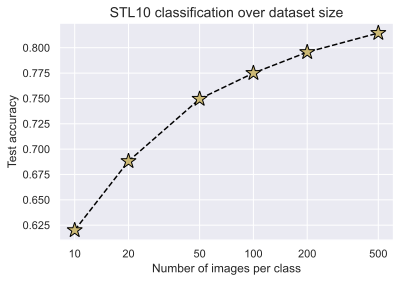

Test accuracy for  10 images per label: 62.00%
Test accuracy for  20 images per label: 68.81%
Test accuracy for  50 images per label: 74.95%
Test accuracy for 100 images per label: 77.50%
Test accuracy for 200 images per label: 79.56%
Test accuracy for 500 images per label: 81.45%


In [30]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

As one would expect, the classification performance improves the more data we have. However, with only 10 images per class, we can already classify more than 60% of the images correctly. This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10. With the full dataset, we achieve an accuracy of 81%. The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset. However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. The implementation of the model is straightforward since the ResNet architecture is provided in the flaxmodels library.

In [31]:
class ResNet(nn.Module):
    num_classes : int

    @nn.compact
    def __call__(self, x, train=True):
        return flaxmodels.ResNet18(output='logits', 
                                   pretrained=False, 
                                   normalize=False,
                                   num_classes=self.num_classes)(x, train=train)

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

Following the same setup as for SimCLR, we apply the resizing augmentation in the data loading, and the remaining augmentations efficiently on GPU.

In [32]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       image_to_numpy])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


In [33]:
def augment_image_for_classification(rng, img):
    rngs = random.split(rng, 3)
    # Random left-right flip
    img = dm_pix.random_flip_left_right(rngs[0], img)
    # Random grayscale
    should_gs = random.bernoulli(rngs[1], p=0.2)
    img = jax.lax.cond(should_gs,  # Only apply grayscale if true
                       lambda x: dm_pix.rgb_to_grayscale(x, keep_dims=True),
                       lambda x: x,
                       img)
    # Gaussian blur
    sigma = random.uniform(rngs[2], shape=(1,), minval=0.1, maxval=0.5)
    img = dm_pix.gaussian_blur(img, sigma=sigma[0], kernel_size=9)
    # Normalization
    img = img * 2.0 - 1.0
    return img

resnet_augm = jax.jit(lambda rng, imgs: jax.vmap(augment_image_for_classification)(random.split(rng, imgs.shape[0]), imgs))

Using this augmentation function, we can define our trainer module, which is an extension of the Logistic Regression trainer to tracking BatchNorm statistics and augmentations.

In [34]:
class RNTrainer(TrainerModule):
    
    def __init__(self, **kwargs):
        super().__init__(model_name=f'ResNet',
                         model_class=ResNet,
                         eval_key='acc',
                         check_val_every_n_epoch=2,
                         **kwargs)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate with a stepwise function
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.7): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.9): 0.1}
        )
        optimizer = optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        self.create_train_state(optimizer)
        
    def create_functions(self):
        # Function to calculate the classification loss and accuracy
        def calculate_loss(params, batch_stats, rng, batch, train):
            imgs, labels = batch
            if train:
                imgs = resnet_augm(rng, imgs)
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            labels_onehot = nn.one_hot(labels, logits.shape[-1])
            loss = optax.softmax_cross_entropy(logits, labels_onehot).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            metrics = {'loss': loss, 'acc': acc}
            return loss, (metrics, new_model_state)
        # Training function
        def train_step(state, batch):
            rng, forward_rng = random.split(state.rng)
            loss_fn = lambda params: calculate_loss(params, 
                                                    state.batch_stats, 
                                                    forward_rng, 
                                                    batch, 
                                                    train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            (_, (metrics, new_model_state)), grads = jax.value_and_grad(loss_fn, 
                                                                        has_aux=True)(state.params)
            # Update parameters, batch statistics and PRNG key
            state = state.apply_gradients(grads=grads, 
                                          batch_stats=new_model_state['batch_stats'],
                                          rng=rng)
            return state, metrics
        # Eval function
        def eval_step(state, rng, batch):
            _, (metrics, _) = calculate_loss(state.params, 
                                             state.batch_stats, 
                                             rng, 
                                             batch, 
                                             train=False)
            return metrics
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

The training function for the ResNet is almost identical to the Logistic Regression setup. Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [35]:
def train_resnet(batch_size, num_epochs=100, **kwargs):
    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, 
                                   batch_size=batch_size, 
                                   shuffle=True, 
                                   drop_last=False, 
                                   generator=torch.Generator().manual_seed(42),
                                   num_workers=3,
                                   persistent_workers=True,
                                   collate_fn=numpy_collate)
    test_loader = data.DataLoader(test_img_data, 
                                  batch_size=batch_size, 
                                  shuffle=False, 
                                  drop_last=False,
                                  num_workers=3,
                                  persistent_workers=True,
                                  collate_fn=numpy_collate)

    # Create a trainer module with specified hyperparameters
    trainer = RNTrainer(exmp_imgs=next(iter(train_loader))[0],
                        **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, test_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    
    # Test best model on validation/test set
    test_result = trainer.eval_model(test_loader)
    result = {"test": test_result["acc"]}
        
    return trainer, result

Finally, let's train the model and check its results:

In [36]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           num_epochs=100)
print(f"Accuracy on test set: {resnet_result['test']:4.2%}")

Accuracy on test set: 71.38%


The ResNet trained from scratch achieves 71.38% on the test set. This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data. This shows that self-supervised, contrastive learning provides considerable performance gains by leveraging large amounts of unlabeled data when little labeled data is available.

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data. Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al.](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020). A simple framework for contrastive learning of visual representations. In International conference on machine learning (pp. 1597-1607). PMLR. ([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020). Big self-supervised models are strong semi-supervised learners. NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O. (2018). Representation learning with contrastive predictive coding. arXiv preprint arXiv:1807.03748. ([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G. and Piot, B. (2020). Bootstrap your own latent: A new approach to self-supervised learning. arXiv preprint arXiv:2006.07733. ([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020). Supervised contrastive learning. arXiv preprint arXiv:2004.11362. ([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021). Barlow twins: Self-supervised learning via redundancy reduction. arXiv preprint arXiv:2103.03230. ([link](https://arxiv.org/abs/2103.03230))

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---